### Problem Statement

A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure and ICP transformation. Due to noise in wheel odometry it generated a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import math
import numpy as np
import os
import gtsam
from scipy.spatial.transform import Rotation as R

# Working with data from Frontend

We recorded the wheel odometry information and RGB-D data from running a husky bot in Gazebo environment using ROS. We have these as ground truth data i.e. without assuming any sensor noise. However, we can still introduce those sensor noise by some changes in urdf files. But for the this tutorial scope we would like to have some external gaussian noise added to GT and then perform optimisation on it.

Once we have those sensor data, now to make Visual Odometry we 

1. Use Feature detector algorithm like SIFT, SURF, ORB, RoRD etc. 
2. Compute 3D points for obtained features.
3. Then perform ICP on points for relative transformation between two poses [loop closure as well as consecutive poses].


SE2 dataset : [Link](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/sudhansh_yelishetty_students_iiit_ac_in/EsWx05OhH7BErb6sxV_CErUBTMfi0wbEjG2j_s8pWFqlXA?e=uLH5S9)

SE3 dataset : [Link](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/sudhansh_yelishetty_students_iiit_ac_in/EpllBgYctm9Dl6ymEUo5uk4Bf-zo8tUpE7_61-JqvKXNig?e=8uu3hj)



In [22]:
def readPoseSE2(filename):
	f = open(filename, 'r')
	A = f.readlines()
	f.close()

	X = []
	Y = []
	THETA = []

	for i, line in enumerate(A):
		if(i % 1 == 0):
			(x, y, theta) = line.split(' ')
			# print(x, y, theta.rstrip('\n'))
			X.append(float(x))
			Y.append(float(y))
			THETA.append(math.radians(float(theta.rstrip('\n'))))

	return X, Y, THETA


def readPoseSE3(filename):
	f = open(filename, 'r')
	A = f.readlines()
	f.close()

	X = []
	Y = []
	Z = []
	Qx = []
	Qy = []
	Qz = []
	Qw = []

	for i, line in enumerate(A):
		if(i % 1 == 0):
			(x, y, z, qx, qy, qz, qw) = line.split(' ')

			X.append(float(x))
			Y.append(float(y))
			Z.append(float(z))
			Qx.append(float(qx))
			Qy.append(float(qy))
			Qz.append(float(qz))
			Qw.append(float(qw.rstrip('\n')))

	return X, Y, Z, Qx, Qy, Qz, Qw



Drawing functions for plotting one, two and three trajectories simultaneously.

In [3]:
def drawSE2(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'k-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'm->')

    plt.show()


def drawTwoSE2(X1, Y1, THETA1, X2, Y2, THETA2):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Noisy')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    plt.legend()
    plt.show()


def drawThreeSE2(X1, Y1, THETA1, X2, Y2, THETA2, X3, Y3, THETA3):
    ax = plt.subplot(111)
    ax.plot(X1, Y1, 'ro', label='Ground Truth')
    plt.plot(X1, Y1, 'k-')

    for i in range(len(THETA1)):
        x2 = 0.25*math.cos(THETA1[i]) + X1[i]
        y2 = 0.25*math.sin(THETA1[i]) + Y1[i]
        plt.plot([X1[i], x2], [Y1[i], y2], 'r->')

    ax.plot(X2, Y2, 'bo', label='Optimized')
    plt.plot(X2, Y2, 'k-')

    for i in range(len(THETA2)):
        x2 = 0.25*math.cos(THETA2[i]) + X2[i]
        y2 = 0.25*math.sin(THETA2[i]) + Y2[i]
        plt.plot([X2[i], x2], [Y2[i], y2], 'b->')

    ax.plot(X3, Y3, 'go', label='Noisy')
    plt.plot(X3, Y3, 'k-')

    for i in range(len(THETA3)):
        x2 = 0.25*math.cos(THETA3[i]) + X3[i]
        y2 = 0.25*math.sin(THETA3[i]) + Y3[i]
        plt.plot([X3[i], x2], [Y3[i], y2], 'g->')

    plt.legend()
    plt.show()	


In [4]:
def drawSE3(X, Y, Z):
	fig = plt.figure()
	ax = plt.axes(projection='3d')
	ax.plot3D(X, Y, Z, 'k-')
	ax.scatter3D(X, Y, Z, c=Z, cmap='Greens')
	ax.set_aspect('auto', 'datalim')
	ax.margins(0.1)
	plt.show()


def drawTwoSE3(X, Y, Z, X2, Y2, Z2):
	fig = plt.figure()
	ax = plt.axes(projection='3d')
	ax.plot3D(X, Y, Z, 'k-',label='Ground Truth')
	ax.scatter3D(X, Y, Z, c=Z, cmap='Reds')
	ax.plot3D(X2, Y2, Z2, 'k-')
	ax.scatter3D(X2, Y2, Z2, c=Z2, cmap='Blues',label='Noisy')
	ax.set_aspect('auto', 'datalim')
	ax.margins(0.1)
	plt.show()

def drawThreeSE3(X, Y, Z, X2, Y2, Z2, X3, Y3, Z3):
	fig = plt.figure()
	ax = plt.axes(projection='3d')
	ax.plot3D(X, Y, Z, 'k-')
	ax.scatter3D(X, Y, Z, c=Z, cmap='Reds',label='Ground Truth')
	ax.plot3D(X2, Y2, Z2, 'k-')
	ax.scatter3D(X2, Y2, Z2, c=Z2, cmap='Blues', label='Optimised')
	ax.plot3D(X3, Y3, Z3, 'k-')
	ax.scatter3D(X3, Y3, Z3, c=Z2, cmap='Greens', label='Noisy')
	ax.set_aspect('auto', 'datalim')
	ax.margins(0.1)
	plt.show()

Adding noise to the trajectory to simulate real life scenario.  
We could not directly add noise values to $X, Y, \theta$ parameters. Instead noise should be added to the odometry values.  
T1_w = $T^w_1$ = 1 with respect to the world

In [5]:
def addNoiseSE2(X, Y, THETA):
    xN = np.zeros(len(X)); yN = np.zeros(len(Y)); tN = np.zeros(len(THETA))
    xN[0] = X[0]; yN[0] = Y[0]; tN[0] = THETA[0]

    for i in range(1, len(X)):
        # Get T2_1
        p1 = (X[i-1], Y[i-1], THETA[i-1])
        p2 = (X[i], Y[i], THETA[i])
        T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
        T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
        del_x = T2_1[0][2]
        del_y = T2_1[1][2]
        del_theta = math.atan2(T2_1[1, 0], T2_1[0, 0])

        # Add noise
        if(i<5):
            xNoise = 0; yNoise = 0; tNoise = 0
        else:
           xNoise = 0.01; yNoise = 0.01; tNoise = 0.0007
        del_xN = del_x + xNoise; del_yN = del_y + yNoise; del_thetaN = del_theta + tNoise

        # Convert to T2_1'
        T2_1N = np.array([[math.cos(del_thetaN), -math.sin(del_thetaN), del_xN], [math.sin(del_thetaN), math.cos(del_thetaN), del_yN], [0, 0, 1]])

        # Get T2_w' = T1_w' . T2_1'
        p1 = (xN[i-1], yN[i-1], tN[i-1])
        T1_wN = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
        T2_wN = np.dot(T1_wN, T2_1N)

        # Get x2', y2', theta2'
        x2N = T2_wN[0][2]
        y2N = T2_wN[1][2]
        theta2N = math.atan2(T2_wN[1, 0], T2_wN[0, 0])

        xN[i] = x2N; yN[i] = y2N; tN[i] = theta2N  

    # tN = getTheta(xN, yN)

    return (xN, yN, tN)



In [6]:
def addNoiseSE3(X, Y, Z, Qx, Qy, Qz, Qw):
	# xN = np.zeros(len(X)); yN = np.zeros(len(Y)); zN = np.zeros(len(Z))

	XN = np.zeros(len(X)); YN = np.zeros(len(Y)); ZN = np.zeros(len(Z))
	QxN = np.zeros(len(Qx)); QyN = np.zeros(len(Qy)); QzN = np.zeros(len(Qz)); QwN = np.zeros(len(Qw))

	XN[0] = X[0]; YN[0] = Y[0]; ZN[0] = Z[0]; QxN[0] = Qx[0]; QyN[0] = Qy[0]; QzN[0] = Qz[0]; QwN[0] = Qw[0]

	for i in range(1, len(X)):
		# Get T2_1
		p1 = (X[i-1], Y[i-1], Z[i-1], Qx[i-1], Qy[i-1], Qz[i-1], Qw[i-1])
		p2 = (X[i], Y[i], Z[i], Qx[i], Qy[i], Qz[i], Qw[i])

		R1_w = R.from_quat([p1[3], p1[4], p1[5], p1[6]]).as_matrix()
		R2_w = R.from_quat([p2[3], p2[4], p2[5], p2[6]]).as_matrix()

		T1_w = np.identity(4)
		T2_w = np.identity(4)

		T1_w[0:3, 0:3] = R1_w
		T2_w[0:3, 0:3] = R2_w

		T1_w[0, 3] = p1[0] 
		T1_w[1, 3] = p1[1]
		T1_w[2, 3] = p1[2]

		T2_w[0, 3] = p2[0]
		T2_w[1, 3] = p2[1]
		T2_w[2, 3] = p2[2]

		T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)

		dx, dy, dz = T2_1[0, 3], T2_1[1, 3], T2_1[2, 3]
		dyaw, dpitch, droll = list(R.from_matrix(T2_1[0:3, 0:3]).as_euler('zyx'))
		# dqx, dqy, dqz, dqw = list(R.from_dcm(T2_1[0:3, 0:3]).as_quat())
		
		# Add noise
		if(i<5):
			xNoise = 0; yNoise = 0; zNoise = 0; rollNoise = 0; pitchNoise = 0; yawNoise = 0
		else:
			xNoise = 0; yNoise = 0; zNoise = 0; rollNoise = 0.00025; pitchNoise = 0.00025; yawNoise = 0.00025

		dx += xNoise; dy += yNoise; dz += zNoise
		dyaw += yawNoise; dpitch += pitchNoise; droll += rollNoise

		# Convert to T2_1'
		R2_1N = R.from_euler('zyx', [dyaw, dpitch, droll]).as_matrix()
		
		T2_1N = np.identity(4)
		T2_1N[0:3, 0:3] = R2_1N

		T2_1N[0, 3] = dx
		T2_1N[1, 3] = dy
		T2_1N[2, 3] = dz

		# Get T2_w' = T1_w' . T2_1'
		p1 = (XN[i-1], YN[i-1], ZN[i-1], QxN[i-1], QyN[i-1], QzN[i-1], QwN[i-1])
		R1_wN = R.from_quat([p1[3], p1[4], p1[5], p1[6]]).as_matrix()
		
		T1_wN = np.identity(4)
		T1_wN[0:3, 0:3] = R1_wN

		T1_wN[0, 3] = p1[0] 
		T1_wN[1, 3] = p1[1]
		T1_wN[2, 3] = p1[2]

		T2_wN = np.dot(T1_wN, T2_1N)

		# Get x2', y2', z2', qx2', qy2', qz2', qw2'
		x2N, y2N, z2N = T2_wN[0, 3], T2_wN[1, 3], T2_wN[2, 3]
		qx2N, qy2N, qz2N, qw2N = list(R.from_matrix(T2_wN[0:3, 0:3]).as_quat())

		XN[i] = x2N; YN[i] = y2N; ZN[i] = z2N
		QxN[i] = qx2N; QyN[i] = qy2N; QzN[i] = qz2N; QwN[i] = qw2N

	return (XN, YN, ZN, QxN, QyN, QzN, QwN)


### Loop Closure Edges

In [28]:

def readLCSE2(filename):
	f = open(filename, 'r')
	A = f.readlines()
	f.close()

	src, trg, trans = [], [], []

	for i, line in enumerate(A):
		if(i%2 == 0):
			st, end = line.split(' ')
			src.append(int(st)); trg.append(int(end.rstrip('\n')))
		else:
			tran = line.split(' ')
			theta = math.radians(float(tran[2].rstrip('\n')))
			trans.append((float(tran[0]), float(tran[1]), float(theta)))

	return src, trg, trans


def readLCSE3(filename):
	f = open(filename, 'r')
	A = f.readlines()
	f.close()

	src, trg, trans = [], [], []

	for i, line in enumerate(A):
		if(i%2 == 0):
			st, end = line.split(' ')
			src.append(int(st)); trg.append(int(end.rstrip('\n')))
		else:
			x, y, z, qx, qy, qz, qw = line.split(' ')
			trans.append((float(x), float(y), float(z), float(qx), float(qy), float(qz), float(qw.rstrip('\n'))))

	return src, trg, trans

In [8]:
def drawLCSE2(X, Y, THETA, srcs, trgs, LDMK=None):
	ax = plt.subplot(111)
	ax.plot(X, Y, 'ro')
	ax.plot(X, Y, 'k-')

	for src, trg in zip(srcs, trgs):
		ax.plot([X[src], X[trg]], [Y[src], Y[trg]], 'b--', markersize=10)
		ax.plot([X[src], X[trg]], [Y[src], Y[trg]], 'bo', markersize=5)

	ax.set_aspect('auto', 'datalim')
	ax.margins(0.1)
	if LDMK is not None:
		for L in LDMK:
			ax.plot(L[0],L[1],'bo')
	plt.show()

def drawLCSE3(X, Y, Z, srcs, trgs):
	fig = plt.figure()
	ax = plt.axes(projection='3d')

	ax.scatter3D(X, Y, Z, c=Z, cmap='Greens', marker='o', s=5)

	for src, trg in zip(srcs, trgs):
		ax.scatter3D(X[src], Y[src], Z[src], c='r', marker='o', s=20)
		ax.scatter3D(X[trg], Y[trg], Z[trg], c='r', marker='o', s=20)

		xline = np.linspace(X[src], X[trg], 1000)
		yline = np.linspace(Y[src], Y[trg], 1000)
		zline = np.linspace(Z[src], Z[trg], 1000)

		ax.plot3D(xline, yline, zline, c='r')

	ax.set_aspect('auto', 'datalim')
	ax.margins(0.1)

	plt.show()

#### Creating g2o files

In [9]:
def writeG2OSE2(X, Y, THETA,noise_file_path,src=None, trg=None, trans=None):
	g2o = open(noise_file_path, 'w')

	for i, (x, y, theta) in enumerate(zip(X, Y, THETA)):
		line = "VERTEX_SE2 " + str(i) + " " + str(x) + " " + str(y) + " " + str(theta)
		g2o.write(line)
		g2o.write("\n")	

	# Odometry
	# T1_w : 1 with respect to world
	g2o.write("# Odometry constraints\n")
	info_mat = "500.0 0.0 0.0 500.0 0.0 500.0"
	for i in range(1, len(X)):
		p1 = (X[i-1], Y[i-1], THETA[i-1])
		p2 = (X[i], Y[i], THETA[i])
		T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
		T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
		T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
		del_x = str(T2_1[0][2])
		del_y = str(T2_1[1][2])
		del_theta = str(math.atan2(T2_1[1, 0], T2_1[0, 0]))

		line = "EDGE_SE2 "+str(i-1)+" "+str(i)+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat+"\n"
		g2o.write(line)

	# LC Constraints
	if src:
		g2o.write('# Loop Closure constraints\n')
		info_mat = "700.0 0.0 0.0 700.0 0.0 700.0\n"
		for i in range(len(src)):
			del_x, del_y, del_theta = str(trans[i][0]), str(trans[i][1]), str(trans[i][2])
			line = "EDGE_SE2 "+str(src[i])+" "+str(trg[i])+" "+del_x+" "+del_y+" "+del_theta+" "+info_mat
			# print(line)
			g2o.write(line)

	g2o.write("FIX 0\n")
	g2o.close()

In [10]:

def writeG2OSE3(X, Y, Z, Qx, Qy, Qz, Qw, noise_file_path, src=None, trg=None, trans=None):
	g2o = open(noise_file_path, 'w')

	sp = ' '

	for i, (x, y, z, qx, qy, qz, qw) in enumerate(zip(X, Y, Z, Qx, Qy, Qz, Qw)):
		line = "VERTEX_SE3:QUAT " + str(i) + sp + str(x) + sp + str(y) + sp + str(z) + sp + str(qx) + sp + str(qy) + sp + str(qz) + sp + str(qw) + '\n'
		g2o.write(line)

	# Odometry
	# T1_w : 1 with respect to world
	g2o.write("\n\n\n# Odometry constraints\n\n\n\n")
	info = '20 0 0 0 0 0 20 0 0 0 0 20 0 0 0 20 0 0 20 0 20'

	for i in range(1, len(X)):
		p1 = (X[i-1], Y[i-1], Z[i-1], Qx[i-1], Qy[i-1], Qz[i-1], Qw[i-1])
		p2 = (X[i], Y[i], Z[i], Qx[i], Qy[i], Qz[i], Qw[i])

		R1_w = R.from_quat([p1[3], p1[4], p1[5], p1[6]]).as_matrix()
		R2_w = R.from_quat([p2[3], p2[4], p2[5], p2[6]]).as_matrix()

		T1_w = np.identity(4)
		T2_w = np.identity(4)

		T1_w[0:3, 0:3] = R1_w
		T2_w[0:3, 0:3] = R2_w

		T1_w[0, 3] = p1[0] 
		T1_w[1, 3] = p1[1]
		T1_w[2, 3] = p1[2]

		T2_w[0, 3] = p2[0]
		T2_w[1, 3] = p2[1]
		T2_w[2, 3] = p2[2]

		T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)

		dx, dy, dz = T2_1[0, 3], T2_1[1, 3], T2_1[2, 3]
		dqx, dqy, dqz, dqw = list(R.from_matrix(T2_1[0:3, 0:3]).as_quat())
		
		line = "EDGE_SE3:QUAT " + str(i-1) + sp + str(i) + sp + str(dx) + sp + str(dy) + sp + str(dz) + sp + str(dqx) + sp + str(dqy) + sp + str(dqz) + sp + str(dqw) + sp +  info + '\n'
		g2o.write(line)


	# LC Constraints
	if src:
		g2o.write("\n\n\n# Loop constraints\n\n\n\n")
		info = '40 0 0 0 0 0 40 0 0 0 0 40 0 0 0 40 0 0 40 0 40'

		for i in range(len(src)):
			line = "EDGE_SE3:QUAT " + str(trg[i]) + sp + str(src[i]) + sp + str(trans[i][0]) + sp + str(trans[i][1]) + sp + str(trans[i][2]) + sp + str(trans[i][3]) + sp + str(trans[i][4]) + sp + \
			str(trans[i][5]) + sp + str(trans[i][6]) + sp +  info + '\n'
			g2o.write(line)


	g2o.write("FIX 0\n")
	g2o.close()



#### Reading G2O files

In [11]:
def readG2oSE2(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    X = []
    Y = []
    THETA = []

    for line in A:
        if "VERTEX_SE2" in line:
            line = line.strip()
            (ver, ind, x, y, theta) = line.split(' ')
            X.append(float(x))
            Y.append(float(y))
            THETA.append(float(theta.rstrip('\n')))

    return (X, Y, THETA)


def readG2oSE3(fileName):
	f = open(fileName, 'r')
	A = f.readlines()
	f.close()

	X = []
	Y = []
	Z = []
	Qx = []
	Qy = []
	Qz = []
	Qw = []

	for line in A:
		if "VERTEX_SE3:QUAT" in line:			
			if(len(line.split(' ')) == 10):
				(ver, ind, x, y, z, qx, qy, qz, qw, newline) = line.split(' ')
			elif(len(line.split(' ')) == 9):
				(ver, ind, x, y, z, qx, qy, qz, qw) = line.split(' ')

			X.append(float(x))
			Y.append(float(y))
			Z.append(float(z))
			Qx.append(float(qx))
			Qy.append(float(qy))
			Qz.append(float(qz))

			if(len(line.split(' ')) == 10):
				Qw.append(float(qw))
			elif(len(line.split(' ')) == 9):
				Qw.append(float(qw.rstrip('\n')))

	return (X, Y, Z, Qx, Qy, Qz, Qw)

## Backend Optimisation [G2O and GTSAM]

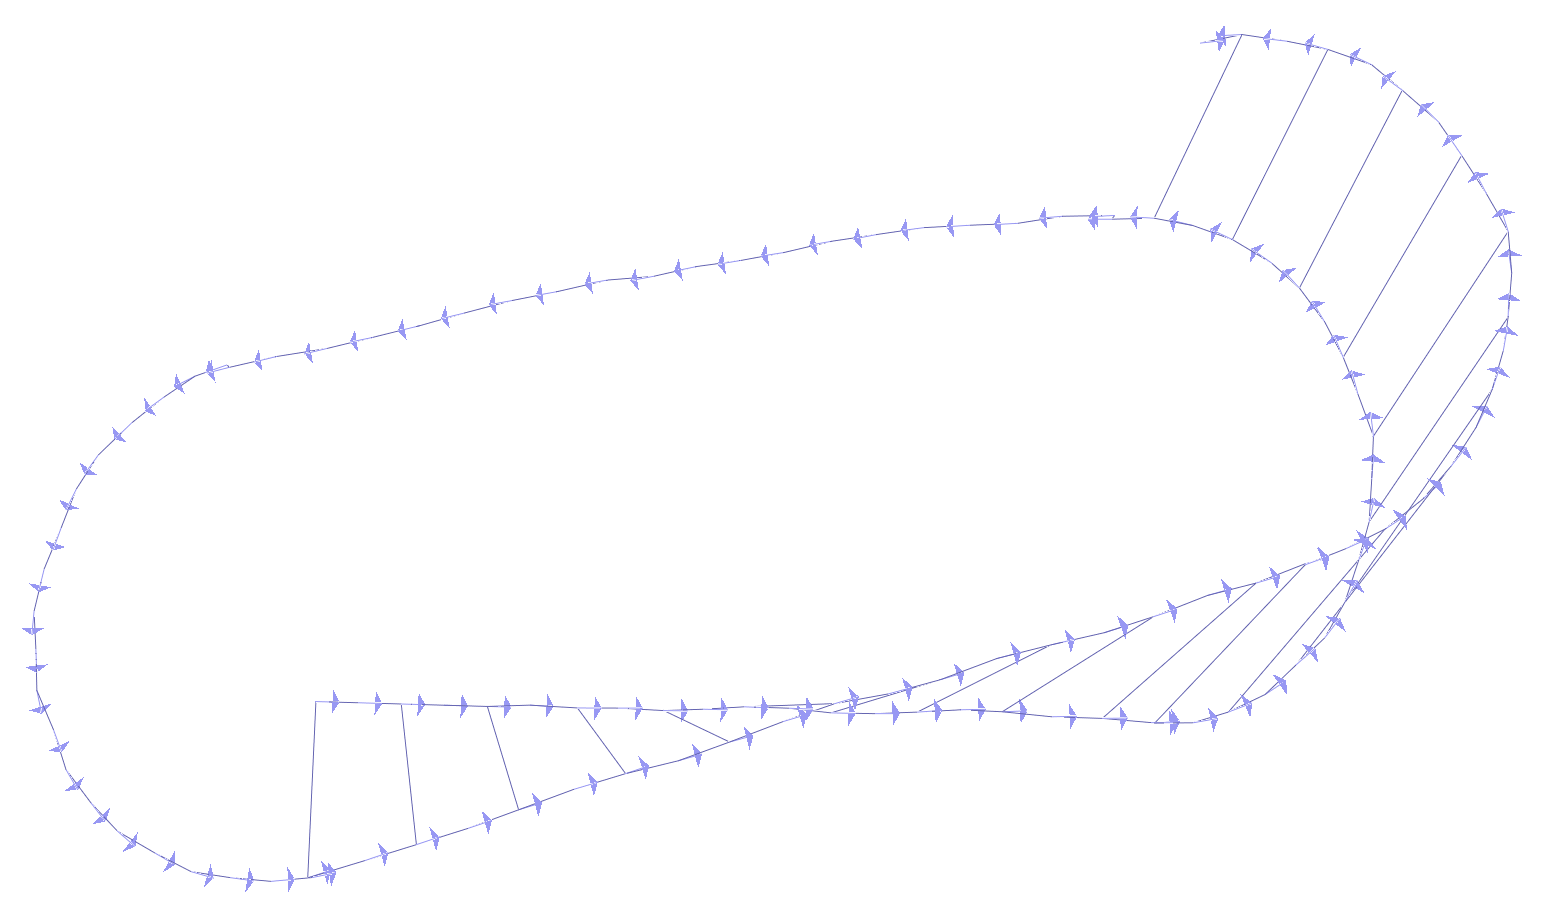

### G2O

In [12]:
def optimize(opt, noise, g2o_path_to_bin = "../../../MR2022/Tutorial/g2o-master/bin/g2o"):
    cmd = g2o_path_to_bin + " -o " + opt + " " + noise
    os.system(cmd)

In [13]:
def optimise_SE2(wheel_odometry_gt, loop_pairs):
    X, Y, THETA = readPoseSE2(wheel_odometry_gt)
    gt_file_path = os.path.join("data_frontend/se2", "gt.g2o")
    writeG2OSE2(X, Y, THETA, gt_file_path)
    (xN, yN, tN) = addNoiseSE2(X, Y, THETA)
    drawTwoSE2(X, Y, THETA, xN, yN, tN)
    src, trg, trans = readLCSE2(loop_pairs)
    drawLCSE2(X, Y, THETA, src, trg)
    drawLCSE2(xN, yN, tN, src, trg)
    noise_file_path = os.path.join("data_frontend/se2", "noise.g2o")
    writeG2OSE2(xN, yN, tN, noise_file_path,src, trg, trans)
    opt_file_path = os.path.join("data_frontend/se2", "opt.g2o")
    optimize(opt_file_path, noise_file_path)
    (xOpt, yOpt, tOpt) = readG2oSE2(opt_file_path)
    drawThreeSE2(X, Y, THETA, xOpt, yOpt, tOpt, xN, yN, tN)

In [14]:
def optimise_SE3(wheel_odometry_gt, loop_pairs):
    X, Y, Z, Qx, Qy, Qz, Qw = readPoseSE3(wheel_odometry_gt)
    gt_file_path = os.path.join("data_frontend/se3", "gt.g2o")
    writeG2OSE3(X, Y, Z, Qx, Qy, Qz, Qw, gt_file_path)
    (XN, YN, ZN, QxN, QyN, QzN, QwN) = addNoiseSE3(X, Y, Z, Qx, Qy, Qz, Qw)
    drawTwoSE3(X, Y, Z, XN, YN, ZN)
    src, trg, trans = readLCSE3(loop_pairs)
    drawLCSE3(X, Y, Z, src, trg)
    drawLCSE3(XN, YN, ZN, src, trg)
    noise_file_path = os.path.join("data_frontend/se3", "noise.g2o")
    writeG2OSE3(XN, YN, ZN, QxN, QyN, QzN, QwN, noise_file_path,src, trg, trans)
    opt_file_path = os.path.join("data_frontend/se3", "opt.g2o")
    optimize(opt_file_path, noise_file_path)
    (XOpt, YOpt, ZOpt, QxOpt, QyOpt, QzOpt, QwOpt) = readG2oSE3(opt_file_path)
    drawThreeSE3(X, Y, Z, XOpt, YOpt, ZOpt, XN, YN, ZN)

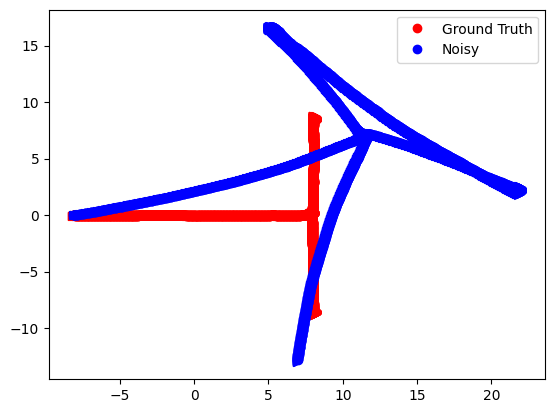

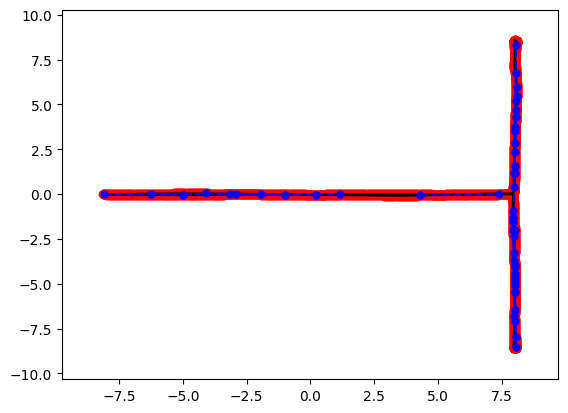

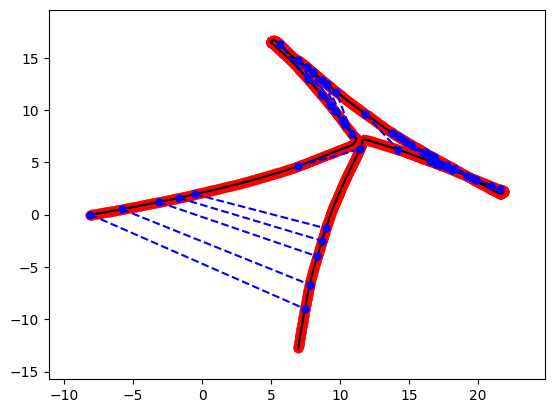

# Using EigenSparseCholesky poseDim -1 landMarkDim -1 blockordering 1
Read input from data_frontend/se2/noise.g2o
Loaded 1830 vertices
Loaded 1853 edges
# graph is fixed by priors or already fixed vertex
Initial chi2 = 508250.825923
saving data_frontend/se2/opt.g2o ... done.


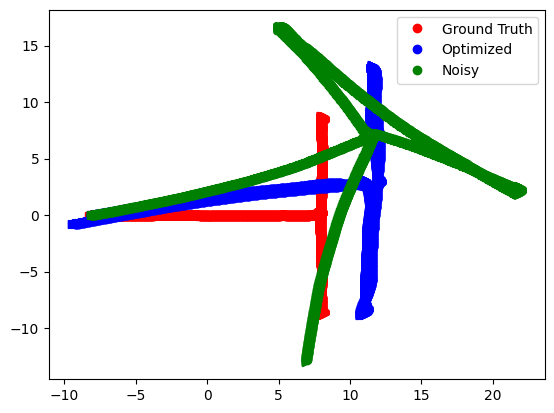

In [15]:
optimise_SE2(os.path.join("data_frontend/se2", "poses.txt"), os.path.join("data_frontend/se2", "loop_pairs.txt"))

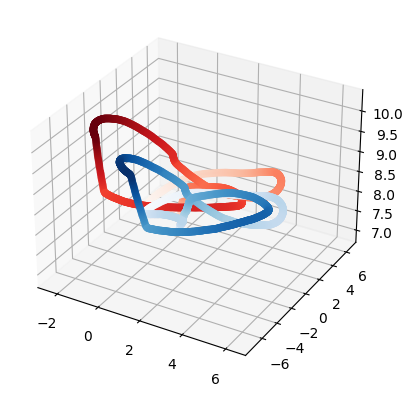

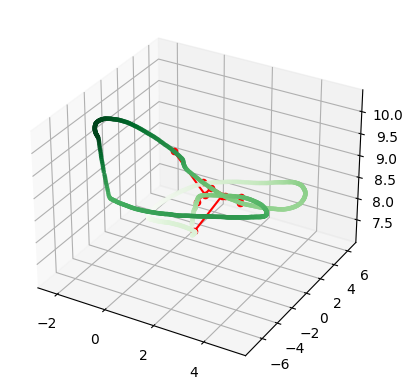

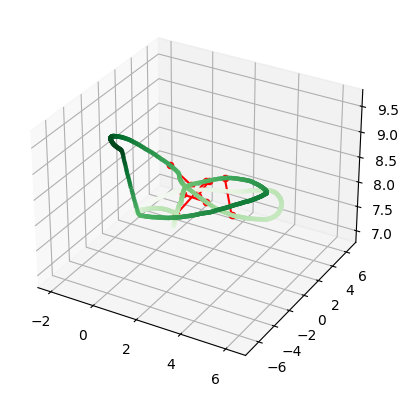

# Using EigenSparseCholesky poseDim -1 landMarkDim -1 blockordering 1
Read input from data_frontend/se3/noise.g2o
Loaded 1695 vertices
Loaded 1699 edges
# graph is fixed by priors or already fixed vertex
Initial chi2 = 154.645544
saving data_frontend/se3/opt.g2o ... done.


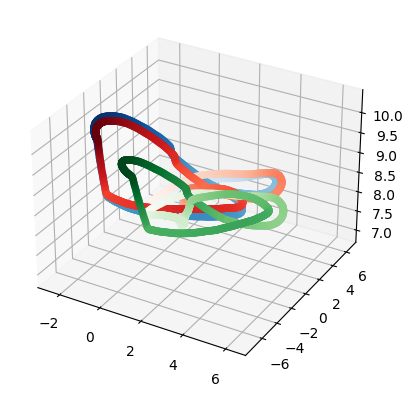

In [16]:
optimise_SE3(os.path.join("data_frontend/se3", "poses.txt"), os.path.join("data_frontend/se3", "loop_pairs.txt"))

In [18]:
# measuring APE/ATE
%run -i g2o_to_kitti.py data_frontend/se2/gt.g2o data_frontend/se2/gt.kitti 0
%run -i g2o_to_kitti.py data_frontend/se2/noise.g2o data_frontend/se2/noise.kitti 0
%run -i g2o_to_kitti.py data_frontend/se2/opt.g2o data_frontend/se2/opt.kitti 0
cmd = "evo_ape kitti data_frontend/se2/gt.kitti data_frontend/se2/noise.kitti  -va --plot --plot_mode xy"
os.system(cmd)
cmd = "evo_ape kitti data_frontend/se2/gt.kitti data_frontend/se2/opt.kitti  -va --plot --plot_mode xy"
os.system(cmd)

saved 'data_frontend/se2/gt.kitti' from 'data_frontend/se2/gt.g2o'
saved 'data_frontend/se2/noise.kitti' from 'data_frontend/se2/noise.g2o'
saved 'data_frontend/se2/opt.kitti' from 'data_frontend/se2/opt.g2o'
--------------------------------------------------------------------------------
Loaded 1830 poses from: data_frontend/se2/gt.kitti
Loaded 1830 poses from: data_frontend/se2/noise.kitti
--------------------------------------------------------------------------------
Aligning using Umeyama's method...
Rotation of alignment:
[[ 0.66471135  0.74710027  0.        ]
 [-0.74710027  0.66471135  0.        ]
 [ 0.          0.          1.        ]]
Translation of alignment:
[-5.44922762  3.83165927  0.        ]
Scale correction: 1.0
--------------------------------------------------------------------------------
Compared 1830 absolute pose pairs.
Calculating APE for translation part pose relation...
--------------------------------------------------------------------------------
APE w.r.t. 

0

In [20]:
# measuring APE/ATE
%run -i g2o_to_kitti.py data_frontend/se3/gt.g2o data_frontend/se3/gt.kitti 1
%run -i g2o_to_kitti.py data_frontend/se3/noise.g2o data_frontend/se3/noise.kitti 1
%run -i g2o_to_kitti.py data_frontend/se3/opt.g2o data_frontend/se3/opt.kitti 1
cmd = "evo_ape kitti data_frontend/se3/gt.kitti data_frontend/se3/noise.kitti  -va --plot --plot_mode xy"
os.system(cmd)
cmd = "evo_ape kitti data_frontend/se3/gt.kitti data_frontend/se3/opt.kitti  -va --plot --plot_mode xy"
os.system(cmd)

saved 'data_frontend/se3/gt.kitti' from 'data_frontend/se3/gt.g2o'
saved 'data_frontend/se3/noise.kitti' from 'data_frontend/se3/noise.g2o'
saved 'data_frontend/se3/opt.kitti' from 'data_frontend/se3/opt.g2o'
--------------------------------------------------------------------------------
Loaded 1695 poses from: data_frontend/se3/gt.kitti
Loaded 1695 poses from: data_frontend/se3/noise.kitti
--------------------------------------------------------------------------------
Aligning using Umeyama's method...
Rotation of alignment:
[[ 0.97930105  0.20051588 -0.02761956]
 [-0.20102377  0.97943868 -0.01700918]
 [ 0.02364105  0.02220929  0.99947379]]
Translation of alignment:
[-0.20963321  0.28547007  0.403011  ]
Scale correction: 1.0
--------------------------------------------------------------------------------
Compared 1695 absolute pose pairs.
Calculating APE for translation part pose relation...
--------------------------------------------------------------------------------
APE w.r.t. 

0

### GTSAM

In [23]:

def pose_symbol(i):
    	return gtsam.symbol_shorthand.X(i)

def ldmk_symbol(i):
    	return gtsam.symbol_shorthand.L(i)


def get_between_factor(p1, p2):
	T1_w = np.array([[math.cos(p1[2]), -math.sin(p1[2]), p1[0]], [math.sin(p1[2]), math.cos(p1[2]), p1[1]], [0, 0, 1]])
	T2_w = np.array([[math.cos(p2[2]), -math.sin(p2[2]), p2[0]], [math.sin(p2[2]), math.cos(p2[2]), p2[1]], [0, 0, 1]])
	T2_1 = np.dot(np.linalg.inv(T1_w), T2_w)
	dx = T2_1[0][2]
	dy = T2_1[1][2]
	dt = math.atan2(T2_1[1, 0], T2_1[0, 0])
	return gtsam.Pose2(dx, dy, dt)


In [24]:


def gtsam_optimisation_python(xN, yN, tN, pairs, pose_sigma, print_log=False):
	graph = gtsam.NonlinearFactorGraph()
	initial = gtsam.Values()
    
	if print_log:
		print("Adding poses...")
        
	for idx in range(len(xN)):
		initial.insert(
			pose_symbol(idx), 
			gtsam.Pose2(xN[idx], yN[idx], tN[idx])
		)

	if print_log:
		print("Adding odom edges...")
        
	priorModel = gtsam.noiseModel.Diagonal.Sigmas(pose_sigma)
	graph.add(gtsam.PriorFactorPose2(pose_symbol(0), gtsam.Pose2(xN[0], yN[0], tN[0]), priorModel))
	for idx in range(len(xN)-1):
			graph.add(gtsam.BetweenFactorPose2(
				pose_symbol(idx),
				pose_symbol(idx+1),
				get_between_factor([xN[idx],yN[idx],tN[idx]],[xN[idx+1],yN[idx+1],tN[idx+1]]),
				priorModel
			))
    

	if print_log:
		print("Adding loop edges...")
	for LP in pairs:
			graph.add(gtsam.BetweenFactorPose2(
				pose_symbol(LP[0]),
				pose_symbol(LP[1]),
				LP[2],
				priorModel
			))
    
	
	params = gtsam.LevenbergMarquardtParams()
	if print_log:
		params.setVerbosity("Termination")  
	params.setMaxIterations(500)
	optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)

	result = optimizer.optimize()

	if print_log:
		print("Optimization complete")
		print("initial error = ", graph.error(initial))
		print("final error = ", graph.error(result))
	marginals = gtsam.Marginals(graph, result)


	final_x = []
	final_y = [] 
	final_t = [] 
	final_ldmk = [] 
	for idx in range(len(xN)):
		final_x.append(result.atPose2(pose_symbol(idx)).x())
		final_y.append(result.atPose2(pose_symbol(idx)).y())
		final_t.append(result.atPose2(pose_symbol(idx)).theta())
		# print("X",idx ," -> ", marginals.marginalCovariance(pose_symbol(idx)))
        

	return final_x, final_y, final_t


In [32]:
def optimise_SE2_gtsam(wheel_odometry_gt, loop_pairs):
    gt_file_path = os.path.join("data_frontend/se2", "gt.g2o")
    X, Y, THETA = readG2oSE2(gt_file_path)
    noise_file_path = os.path.join("data_frontend/se2", "noise.g2o")
    (xN, yN, tN) = readG2oSE2(noise_file_path)
    src, trg, trans = readLCSE2(loop_pairs)

    LP = []
    for i in range(len(src)):
        LP.append([
            src[i],
            trg[i],
            gtsam.Pose2(trans[i][0], trans[i][1], trans[i][2])
        ])
    pose_sigma = np.array([ 100, 100, 100 ])
    (xOpt, yOpt, tOpt) =  gtsam_optimisation_python(xN, yN, tN, LP,pose_sigma, True)
    opt_file_path = os.path.join("data_frontend/se2", "opt_gtsam.g2o")
    writeG2OSE2(xOpt, yOpt, tOpt, opt_file_path)
    drawThreeSE2(X, Y, THETA, xOpt, yOpt, tOpt, xN, yN, tN)

Adding poses...
Adding odom edges...
Adding loop edges...
converged
errorThreshold: 3.59829092779e-05 <? 0
absoluteDecrease: 2.51709561396e-06 <? 1e-05
relativeDecrease: 0.0653790985489 <? 1e-05
iterations: 8 >? 500
Optimization complete
initial error =  0.0363036304230853
final error =  3.598290927793216e-05


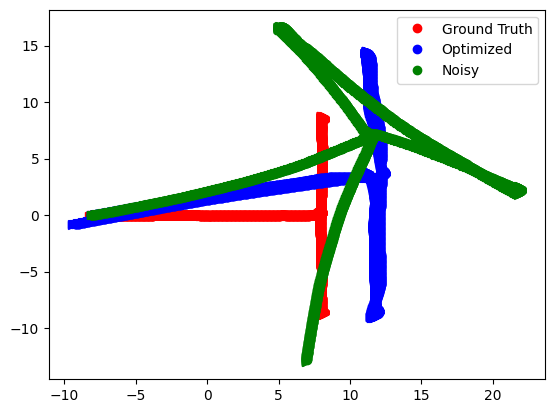

In [33]:
optimise_SE2_gtsam(os.path.join("data_frontend/se2", "poses.txt"), os.path.join("data_frontend/se2", "loop_pairs.txt"))

In [34]:
# measuring APE/ATE
%run -i g2o_to_kitti.py data_frontend/se2/opt_gtsam.g2o data_frontend/se2/opt_gtsam.kitti 0
cmd = "evo_ape kitti data_frontend/se2/gt.kitti data_frontend/se2/opt_gtsam.kitti  -va --plot --plot_mode xy"
os.system(cmd)

saved 'data_frontend/se2/opt_gtsam.kitti' from 'data_frontend/se2/opt_gtsam.g2o'
--------------------------------------------------------------------------------
Loaded 1830 poses from: data_frontend/se2/gt.kitti
Loaded 1830 poses from: data_frontend/se2/opt_gtsam.kitti
--------------------------------------------------------------------------------
Aligning using Umeyama's method...
Rotation of alignment:
[[ 0.99556323  0.09409493  0.        ]
 [-0.09409493  0.99556323  0.        ]
 [ 0.          0.          1.        ]]
Translation of alignment:
[-2.92087037 -1.68382124  0.        ]
Scale correction: 1.0
--------------------------------------------------------------------------------
Compared 1830 absolute pose pairs.
Calculating APE for translation part pose relation...
--------------------------------------------------------------------------------
APE w.r.t. translation part (m)
(with SE(3) Umeyama alignment)

       max	4.500095
      mean	1.981546
    median	1.920820
       min	

0

<Figure size 640x480 with 0 Axes>

In [ ]:
# similarly we can code for SE3 case also!